In [ ]:
!pip install pysus
!pip install sidrapy
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.6 MB/s eta 0:00:00


In [ ]:
# conectar com o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/Datathon Brazil 2025/"

import os
# Diretório para armazenar os dados
os.makedirs('Dataset_Desafio_1', exist_ok=True)

/content/drive/MyDrive/Datathon Brazil 2025


In [ ]:
from pysus.online_data.CNES import download as download_cnes
from pysus.online_data.SIH import download as download_sih
from pysus.online_data.SIA import download as download_sia
from pysus.online_data.SIM import download as download_sim
from pysus.online_data.SINAN import download as download_sinan
from pysus.online_data import IBGE
from pysus import CNES as pysusCNES
from pysus import SIH as pysusSIH
from pysus import SIA as pysusSIA
from pysus import SIM as pysusSIM
from pysus import SINAN as pysusSINAN

import pandas as pd

import matplotlib.pyplot as plt

import geopandas as gpd
import fiona
import sidrapy as sd

# Desafio 1: Acessibilidade Hospitalar em Manaus

O acesso a cuidados oportunos é um pilar fundamental da equidade em saúde. Em uma cidade extensa como Manaus — onde estradas, travessias de rios e assentamentos informais moldam a vida cotidiana — algumas comunidades enfrentam tempos de viagem desproporcionalmente longos para chegar a hospitais de emergência e especializados. Ao analisar onde as instalações, a população e as redes viárias se cruzam, você pode identificar lacunas no acesso e iniciar discussões de planejamento baseadas em dados.

**Dados Disponíveis**

- **CNES (Cadastro Nacional de Estabelecimentos de Saúde)**: Pontos geocodificados para todas as unidades de saúde no Amazonas, incluindo contagem de leitos e tipos de serviço.

- **Malha Viária (Geofabrik Shapefiles)**: O extrato completo do OSM para o Amazonas, com camadas dedicadas para ruas transitáveis, edifícios, entre outros.

- **População por Setor (Tabelas SIDRA)**: Do censo, inclui a população total e outros (idade, sexo) no nível do setor censitário.

**Dica**: Você pode enriquecer isso com dados em tempo real disponíveis online, como ônibus, rotas de Navegação Fluvial (ANTAQ) ou mapas de atividades obtidos por celular, se desejar.

**Objetivo**  

Entender e quantificar as desigualdades de acesso a serviços de saúde na região Amazônica — levando em conta localização de hospitais, características demográficas e infraestrutura de transporte — e desenvolver ferramentas analíticas capazes de orientar gestores públicos na priorização de investimentos, expansão de cobertura e redução de gargalos assistenciais.

**Perguntas Motivacionais**  

- Quais áreas apresentam maior tempo de deslocamento até o serviço de saúde mais próximo?  
- Como variáveis socioeconômicas (renda, escolaridade, raça) se relacionam com a oferta de leitos e serviços?  
- Onde a criação de novas unidades ou a melhoria de rotas viárias traria maior impacto na cobertura assistencial?  
- É possível elaborar índices compostos de vulnerabilidade espacial que orientem decisões de alocação de recursos?

----
**English**

# Challenge 1: Hospital Accessibility in Manaus

Access to timely care is a cornerstone of health equity. In a sprawling city like Manaus—where roads, river crossings, and informal settlements shape daily life—some communities face disproportionately long travel times to reach emergency and specialty hospitals. By analyzing where facilities, population, and street networks intersect, you can pinpoint gaps in access and spark data-driven planning discussions.

**Available Data**

- **CNES (Cadastro Nacional de Estabelecimentos de Saúde)**: Geocoded points for all health facilities in Amazonas, including bed counts and service types.

- **Road Network (Geofabrik Shapefiles)**: The full OSM extract for Amazonas, with a dedicated layers for drivable streets, buildings, among others.

- **Population by Tract (SIDRA Tables)**: From census includes total population and others (age, sex) at the census-tract level.

**Tip**: You can enrich this with real-time data avialble online, such as bus, River Navigation routes (ANTAQ), or mobile-phone–derived activity maps if you like.

**Objective**  

Characterize and measure healthcare-access inequalities across the Amazon region—considering hospital locations, demographic patterns, and transportation infrastructure—and build analytical tools that support policymakers in targeting investments, expanding coverage, and alleviating care gaps.

**Motivational Questions**  

- Which zones have the longest travel times to the nearest health facility?  
- How do socioeconomic factors (income, education, race) correlate with bed availability and service provision?  
- Where would adding new facilities or upgrading road networks yield the greatest improvement in coverage?  
- Can composite spatial-vulnerability indices be designed to guide resource-allocation decisions?


In [ ]:
# Definir parâmetros
group_CNES = ['ST','LT'] # Estabelecimentos, Leitos
group_SIH = 'RD' # AIH Reduzida (Reduced Hospital Admission Authorization)
group_SIA = 'PA' # Produção Ambulatorial
states = ['AM'] # Amazonas
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
year = 2024

In [ ]:
def parquets_to_dataframe(files):
    """
    Converte um ou vários arquivos Parquet em um único DataFrame pandas,
    removendo colunas cujo valor é constante em todas as linhas.

    Parâmetros
    ----------
    files : list ou objeto com método to_dataframe()
        - Se for uma lista, cada elemento deve ser um objeto que implemente
          o método `.to_dataframe()`, retornando um pandas.DataFrame.
        - Se for um único objeto, deve implementar `.to_dataframe()`.

    Retorno
    -------
    pandas.DataFrame
        DataFrame resultante da concatenação (quando `files` é lista) ou da
        conversão direta (quando `files` é um único objeto). Colunas com apenas
        um valor único são removidas automaticamente.

    Exemplo
    -------
    >>> # Convertendo múltiplos arquivos Parquet
    >>> df = parquets_to_dataframe([pq1, pq2, pq3])
    (1000, 25)
    (800, 25)
    (1200, 25)
    >>> print(df.shape)
    (3000, 25)

    >>> # Convertendo um único arquivo
    >>> df = parquets_to_dataframe(pq1)
    """
    if (type(files) is list):
      df = []
      for aux_file in files:
          aux_file = aux_file.to_dataframe()
          print(aux_file.shape)
          df.append(aux_file)

      df = pd.concat(df)
    else:
      df = files.to_dataframe()

    # Remover colunas com 1 valor único
    df = df.loc[:, df.nunique() > 1]
    return df

### CNES (Cadastro Nacional de Estabelecimentos de Saúde)

In [ ]:
cnes = pysusCNES()
print('Metadatos: ')
print(cnes.metadata)
cnes.load()
print('Grupos: ')
print(cnes.groups)

Metadatos: 
{'long_name': 'Cadastro Nacional de Estabelecimentos de Saúde', 'source': 'https://cnes.datasus.gov.br/', 'description': 'O Cadastro Nacional de Estabelecimentos de Saúde (CNES) é o sistema de informação oficial de cadastramento de informações de todos os estabelecimentos de saúde no país, independentemente de sua natureza jurídica ou de integrarem o Sistema Único de Saúde (SUS). Trata-se do cadastro oficial do Ministério da Saúde (MS) no tocante à realidade da capacidade instalada e mão-de-obra assistencial de saúde no Brasil em estabelecimentos de saúde públicos ou privados, com convênio SUS ou não.'}
Grupos: 
{'DC': 'Dados Complementares', 'EE': 'Estabelecimento de Ensino', 'EF': 'Estabelecimento Filantrópico', 'EP': 'Equipes', 'EQ': 'Equipamentos', 'GM': 'Gestão e Metas', 'HB': 'Habilitação', 'IN': 'Incentivos', 'LT': 'Leitos', 'PF': 'Profissional', 'RC': 'Regra Contratual', 'SR': 'Serviço Especializado', 'ST': 'Estabelecimentos'}


In [ ]:
# Obtenha dados do CNES 2024 para o Amazonas (Estabelecimentos)
files = download_cnes(group=group_CNES[0], states=states, years=[year], months=months)

df_cnes_2024 = parquets_to_dataframe(files)

df_cnes_2024.head()

139496it [00:00, 8738926.85it/s]      


(2902, 208)
(2918, 208)
(2944, 208)
(2915, 208)
(2933, 208)
(2955, 208)
(2974, 208)
(2970, 208)
(2996, 208)
(3002, 208)
(3028, 208)
(3031, 208)


,CNES,CODUFMUN,COD_CEP,CPF_CNPJ,PF_PJ,NIV_DEP,CNPJ_MAN,REGSAUDE,DISTRSAN,VINC_SUS,...,AP06CV01,AP06CV02,AP06CV06,AP06CV07,AP07CV01,AP07CV02,AP07CV07,DT_ATUAL,COMPETEN,NAT_JUR
0,2016451,130002,69540000,00000000000000,3,3,04628335000100,002,,1,...,0,0,0,0,0,0,0,202312,202401,1244
1,2017768,130002,69540000,00000000000000,3,3,04628335000100,002,,1,...,0,0,0,0,0,0,0,202308,202401,1244
2,6570275,130002,69540000,00000000000000,3,3,04628335000100,,,1,...,1,0,0,0,0,0,0,202312,202401,1244
3,6721265,130002,69540000,00000000000000,3,3,04628335000100,,,1,...,1,0,0,0,0,0,0,202307,202401,1244
4,6834132,130002,69540000,00000000000000,3,3,04628335000100,02,,1,...,1,0,0,0,0,0,0,202312,202401,1244


In [ ]:
# Salvar como arquivo csv
df_cnes_2024.to_csv('Dataset_Desafio_1/cnes_2024_Estabelecimentos.csv', index=False)

In [ ]:
# Obtenha dados do CNES 2024 para o Amazonas (Leitos)
files_beds = download_cnes(group=group_CNES[1], states=states, years=[year], months=months)#.to_dataframe()

df_cnes_beds_2024 = parquets_to_dataframe(files_beds)

# Salvar como arquivo csv
df_cnes_beds_2024.to_csv('Dataset_Desafio_1/cnes_2024_Leitos.csv', index=False)

df_cnes_beds_2024.head()

9689it [00:00, 2259960.60it/s]        


(713, 28)
(717, 28)
(725, 28)
(722, 28)
(728, 28)
(733, 28)
(738, 28)
(743, 28)
(746, 28)
(735, 28)
(747, 28)
(749, 28)


,CNES,CODUFMUN,REGSAUDE,DISTRSAN,TPGESTAO,CPF_CNPJ,NIV_DEP,CNPJ_MAN,ATIVIDAD,CLIENTEL,TP_UNID,TURNO_AT,TP_LEITO,CODLEITO,QT_EXIST,QT_SUS,QT_NSUS,COMPETEN,NAT_JUR
0,2017768,130002,002,,M,00000000000000,3,04628335000100,04,03,05,06,2,41,4,4,0,202401,1244
1,2017768,130002,002,,M,00000000000000,3,04628335000100,04,03,05,06,2,33,18,18,0,202401,1244
2,2017768,130002,002,,M,00000000000000,3,04628335000100,04,03,05,06,3,95,2,2,0,202401,1244
3,2017768,130002,002,,M,00000000000000,3,04628335000100,04,03,05,06,5,45,4,4,0,202401,1244
4,2017768,130002,002,,M,00000000000000,3,04628335000100,04,03,05,06,4,43,4,4,0,202401,1244


### SIH (Sistema de Informações Hospitalares)

In [ ]:
sih = pysusSIH()
print('Metadatos: ')
print(sih.metadata)
sih.load()
print('Groupos: ')
print(sih.groups)
# 'RD': AIH Reduzida (Reduced Hospital Admission Authorization)

Metadatos: 
{'long_name': 'Sistema de Informações Hospitalares', 'source': ('https://datasus.saude.gov.br/acesso-a-informacao/morbidade-hospitalar-do-sus-sih-sus/', 'https://datasus.saude.gov.br/acesso-a-informacao/producao-hospitalar-sih-sus/'), 'description': 'A finalidade do AIH (Sistema SIHSUS) é a de transcrever todos os atendimentos que provenientes de internações hospitalares que foram financiadas pelo SUS, e após o processamento, gerarem relatórios para os gestores que lhes possibilitem fazer os pagamentos dos estabelecimentos de saúde. Além disso, o nível Federal recebe mensalmente uma base de dados de todas as internações autorizadas (aprovadas ou não para pagamento) para que possam ser repassados às Secretarias de Saúde os valores de Produção de Média e Alta complexidade além dos valores de CNRAC, FAEC e de Hospitais Universitários – em suas variadas formas de contrato de gestão.'}
Groupos: 
{'RD': 'AIH Reduzida', 'RJ': 'AIH Rejeitada', 'ER': 'AIH Rejeitada com erro', 'SP': 

In [ ]:
# Obtenha dados do SIH 2024 para o Amazonas
sih_files = download_sih(groups=group_SIH, states=states, years=[year], months=months)

df_sih_2024 = parquets_to_dataframe(sih_files)

# Salvar como arquivo csv
df_sih_2024.to_csv('Dataset_Desafio_1/sih_2024_AIH.csv', index=False)

df_sih_2024.head()

1140050it [00:00, 185936006.35it/s]   


(15990, 113)
(18532, 113)
(19267, 113)
(19407, 113)
(20218, 113)
(18921, 113)
(19286, 113)
(18733, 113)
(19962, 113)
(20051, 113)
(18310, 113)
(16683, 113)


,UF_ZI,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,CEP,MUNIC_RES,NASC,SEXO,UTI_MES_TO,...,DIAGSEC5,DIAGSEC6,DIAGSEC7,TPDISEC1,TPDISEC2,TPDISEC3,TPDISEC4,TPDISEC5,TPDISEC6,TPDISEC7
0,130000,01,07,04332939000104,1323103294910,69006562,130260,20211104,3,0,...,,,,0,0,0,0,0,0,0
1,130000,01,07,04332939000104,1323103294953,69087047,130260,20230302,3,0,...,,,,0,0,0,0,0,0,0
2,130000,01,07,04332939000104,1323103295393,69086384,130260,20211020,3,0,...,,,,2,0,0,0,0,0,0
3,130000,01,07,04332939000104,1323103295569,69089060,130260,20180115,1,0,...,,,,0,0,0,0,0,0,0
4,130000,01,07,00697295004780,1324100117560,69067471,130260,20210727,3,0,...,,,,0,0,0,0,0,0,0


In [ ]:
#for column in df_sih_2024.columns: print(column)

### SIA (Sistema de Informações Ambulatoriais) (Opcional)

In [ ]:
sia = pysusSIA()
print('Metadatos: ')
print(sia.metadata)
sia.load()
print('Groupos: ')
print(sia.groups)

Metadatos: 
{'long_name': 'Sistema de Informações Ambulatoriais', 'source': 'http://sia.datasus.gov.br/principal/index.php', 'description': 'O Sistema de Informação Ambulatorial (SIA) foi instituído pela Portaria GM/MS n.º 896 de 29 de junho de 1990. Originalmente, o SIA foi concebido a partir do projeto SICAPS (Sistema de Informação e Controle Ambulatorial da Previdência Social), em que os conceitos, os objetivos e as diretrizes criados para o desenvolvimento do SICAPS foram extremamente importantes e amplamente utilizados para o desenvolvimento do SIA, tais como: (i) o acompanhamento das programações físicas e orçamentárias; (ii) o acompanhamento das ações de saúde produzidas; (iii) a agilização do pagamento e controle orçamentário e financeiro; e (iv) a formação de banco de dados para contribuir com a construção do SUS.'}
Groupos: 
{'AB': 'APAC de Cirurgia Bariátrica', 'ABO': 'APAC de Acompanhamento Pós Cirurgia Bariátrica', 'ACF': 'APAC de Confecção de Fístula', 'AD': 'APAC de Laud

In [ ]:
# Baixar e processar dados
#sia_files = download_sia(groups=group_SIA, states=states, years=[year], months=months)
#df_sia_2024 = parquets_to_dataframe(sia_files)
# Salvar como arquivo csv
#df_sia_2024.to_csv('Dataset_Desafio_1/sia_2024_ProducaoAmbulatorial.csv', index=False)
#df_sia_2024.head()

In [ ]:
#df_sia_2024.columns

### Geofabrik
Dados georreferenciados de estradas, edifícios, fontes de água, etc.

from: https://download.geofabrik.de/south-america/brazil

In [ ]:
path = "/content/drive/MyDrive/Datathon Brazil 2025/Shapefiles/norte-latest-free.shp.zip"

layers = fiona.listlayers(path)
print(layers)

shapefile_path = path

# Carregar em um GeoDataFrame
roads = gpd.read_file(shapefile_path, layer="gis_osm_roads_free_1")
water = gpd.read_file(shapefile_path, layer="gis_osm_waterways_free_1")
roads

['gis_osm_buildings_a_free_1', 'gis_osm_landuse_a_free_1', 'gis_osm_natural_a_free_1', 'gis_osm_natural_free_1', 'gis_osm_places_a_free_1', 'gis_osm_places_free_1', 'gis_osm_pofw_a_free_1', 'gis_osm_pofw_free_1', 'gis_osm_pois_a_free_1', 'gis_osm_pois_free_1', 'gis_osm_railways_free_1', 'gis_osm_roads_free_1', 'gis_osm_traffic_a_free_1', 'gis_osm_traffic_free_1', 'gis_osm_transport_a_free_1', 'gis_osm_transport_free_1', 'gis_osm_water_a_free_1', 'gis_osm_waterways_free_1']


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,19212642,5132,trunk_link,Avenida Santos Dumont,None,F,60,0,F,F,"LINESTRING (-60.022 -3.03504, -60.02304 -3.035..."
1,22901861,5122,residential,None,None,B,40,0,F,F,"LINESTRING (-46.77759 -1.01626, -46.77751 -1.0..."
2,22901863,5141,service,None,None,B,0,0,F,F,"LINESTRING (-46.74081 -0.97452, -46.74062 -0.9..."
3,22901865,5122,residential,None,None,B,40,0,F,F,"LINESTRING (-46.77692 -1.01252, -46.7758 -1.01..."
4,22901870,5121,unclassified,None,None,B,40,0,F,F,"LINESTRING (-46.8034 -0.99999, -46.80373 -0.99..."
...,...,...,...,...,...,...,...,...,...,...,...
425608,1387356578,5122,residential,Rua Maria Amorim Neves,None,B,30,0,F,F,"LINESTRING (-60.06332 -3.10521, -60.06354 -3.1..."
425609,1387356579,5122,residential,Rua Maria Amorim Neves,None,B,30,0,F,F,"LINESTRING (-60.06314 -3.10494, -60.06322 -3.1..."
425610,1387368901,5122,residential,None,None,B,0,0,F,F,"LINESTRING (-59.90992 -7.20104, -59.90977 -7.2..."
425611,1387368902,5122,residential,None,None,B,0,0,F,F,"LINESTRING (-59.90835 -7.20033, -59.90942 -7.1..."


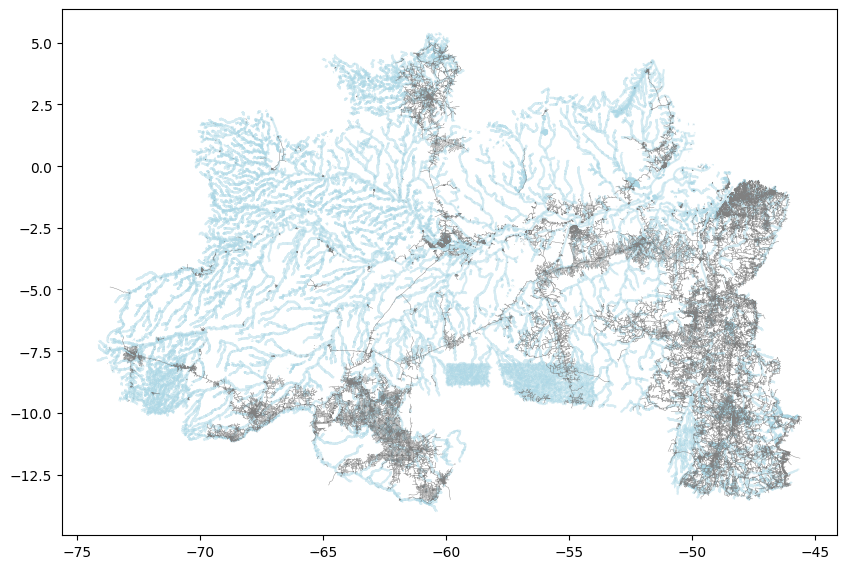

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# Trace a água primeiro em azul claro
water.plot(ax=ax, color="lightblue", alpha=0.5)
# Traçar estradas no topo
roads.plot(ax=ax, linewidth=0.3, color="gray")
plt.show()

### Census

In [ ]:
# Tabela 6579 = população total por município
data = sd.get_table(table_code="6579", territorial_level="6", ibge_territorial_code="all", period="last")
# Salvar como arquivo csv
data.to_csv('Dataset_Desafio_1/populacao.csv', index=False)
data

,NC,NN,MC,MN,V,D1C,D1N,D2C,D2N,D3C,D3N
0,Nível Territorial (Código),Nível Territorial,Unidade de Medida (Código),Unidade de Medida,Valor,Município (Código),Município,Ano (Código),Ano,Variável (Código),Variável
1,6,Município,45,Pessoas,22853,1100015,Alta Floresta D'Oeste - RO,2024,2024,9324,População residente estimada
2,6,Município,45,Pessoas,108573,1100023,Ariquemes - RO,2024,2024,9324,População residente estimada
3,6,Município,45,Pessoas,5690,1100031,Cabixi - RO,2024,2024,9324,População residente estimada
4,6,Município,45,Pessoas,97637,1100049,Cacoal - RO,2024,2024,9324,População residente estimada
...,...,...,...,...,...,...,...,...,...,...,...
5566,6,Município,45,Pessoas,15476,5222005,Vianópolis - GO,2024,2024,9324,População residente estimada
5567,6,Município,45,Pessoas,9077,5222054,Vicentinópolis - GO,2024,2024,9324,População residente estimada
5568,6,Município,45,Pessoas,4185,5222203,Vila Boa - GO,2024,2024,9324,População residente estimada
5569,6,Município,45,Pessoas,5982,5222302,Vila Propício - GO,2024,2024,9324,População residente estimada
